<a href="https://colab.research.google.com/github/SihaoCheng/scattering_transform/blob/master/PH_image_synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import torch
import time

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
import ST

save_dir = 'drive/My Drive/Colab Notebooks/'
colab_dir = 'drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


# checking information of the GPU used 

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 10 13:54:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Synthesis based on images

In [5]:
def smooth(image, j):
    M = image.shape[-2]
    N = image.shape[-1]
    X = np.arange(M)[:,None]
    Y = np.arange(N)[None,:]
    R2 = (X-M//2)**2 + (Y-N//2)**2
    weight_f = torch.from_numpy(np.fft.fftshift(np.exp(-0.5 * R2 / (M//(2**j)//2)**2))).cuda()
    image_smoothed = torch.fft.ifftn(
        torch.fft.fftn(
            image, dim=(-2,-1)
        ) * weight_f[None,:,:],
        dim=(-2,-1)
    )
    return image_smoothed.real

In [7]:
def image_synthesis(image, J, L, N_realization=1,
                    learnable_param_list = [(100, 1e-3)],
                    savedir = '',
                    device='cpu',
                    coef = 'PH',
                    random_seed = 987,
                    low_bound = -0.010,
                    high_bound = 1,
                    angular_factor = 1.0,
                    starting_power_factor = 1.0,
                    starting_image = None,
                    ST_norm = 1,
                    ST_algorithm = 'fast',
                    flip = True,
                    optim_mode='Adam',
                    mean_shift_init=1,
                    if_remove_edge=0,
                    filter='morlet'
):

    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    N_image = image.shape[0]
    M = image.shape[1]
    N = image.shape[2]
    if flip:
        flip_factor = 2
    else:
        flip_factor = 1
    if filter=='morlet':
        filters_set = ST.FiltersSet(
            M=M*flip_factor, N=N*flip_factor, J=J, L=L
        ).generate_morlet(
            if_save=False, save_dir=None, precision='single'
        )
    if filter=='BS':
        filters_set = ST.FiltersSet(
            M=M*flip_factor, N=N*flip_factor, J=J, L=L
        ).generate_bump_steerable(
            if_save=False, save_dir=None, precision='single'
        )
    if filter=='gau':
        filters_set = ST.FiltersSet(
            M=M*flip_factor, N=N*flip_factor, J=J, L=L
        ).generate_gau_steerable(
            if_save=False, save_dir=None, precision='single'
        )
    ST_calculator = ST.ST_2D(filters_set, J, L, device=device)
    
    bin_edges = np.linspace(150/(360/3.5), M/2*1.4, 7) # in unit of pixel in Fourier space
    bispectrum_calculator = ST.Bispectrum_Calculator(
        bin_edges, M*flip_factor, N*flip_factor, device=device
    )
    image_torch = torch.from_numpy(image).type(torch.FloatTensor) + 5
    if flip:
        image_flip_torch = torch.cat((
            torch.cat((
                image_torch, torch.flip(image_torch,[1])),1),
            torch.cat((
                torch.flip(image_torch,[2]), torch.flip(image_torch,[1,2])),1)), 2
        )
    else:
        image_flip_torch = image_torch

    if device=='gpu':
        image_torch = image_torch.cuda()
        image_flip_torch = image_flip_torch.cuda()
    
    plt.imshow(image_flip_torch[0].cpu().detach().numpy()-5)
    plt.show()

    target_bi = bispectrum_calculator.forward(image_flip_torch)
    target_ST_all = ST_calculator.forward(
        image_flip_torch, J, L, 
        algorithm=ST_algorithm, if_C01=('C' in coef),
        pseudo_coef=1, if_remove_edge=if_remove_edge)
    target_PH_all = ST_calculator.phase_harmonics(
        image_flip_torch, J, L)
    target_mean = target_ST_all[0][:,0]
    target_ST = target_ST_all[0][:,1:]
    select = (target_ST[0]!=0)
    target_ST = target_ST.log()[:,select]
    target_H = target_ST_all[-2]
    select = (target_H[0]!=0)
    target_H = target_H.log()[:,select]
    if 'ST' in coef:
        if 'C' in coef:
            target_C01 = target_ST_all[-1]
            select_C01 = (target_C01[0]!=0)
            target_C01 = target_C01[:,select_C01]
    if 'PH' in coef:

        target_C01 = target_PH_all['C01_r']
        select_C01 = (target_C01[0]!=0)
        target_C01 = target_C01[:,select_C01]
        
        target_PH00 = target_PH_all['C00'].sum(-1)
        target_S1 = target_PH_all['S1'].sum(-1)

        target_PH11diag = target_PH_all['C11diag_r'].reshape((N_image,-1))
        select_PH11diag = (target_PH11diag[0]>-9999)
        target_PH11diag = target_PH11diag[:,select_PH11diag]

        target_PH11 = target_PH_all['C11'] / (
            target_PH_all['C11diag'][:,:,:,None,None,:,:] *
            target_PH_all['C11diag'][:,None,None,:,:,:,:]
        )**0.5
        target_PH11_reduced = torch.zeros_like(target_PH11).sum(2)
        for l1 in range(L):
            for l2 in range(L):
                for l3 in range(L):
                    target_PH11_reduced[:,:,:,(l2-l1)%L,:,(l3-l1)%L] += target_PH11[:,:,l1,:,l2,:,l3]
        target_PH11_reduced /= L
        select_PH11 = (target_PH11_reduced[0].flatten().abs()<=1) * (target_PH11_reduced[0].flatten()!=0)
        print(select_PH11.sum())
    target_cumsum0 = image_torch.reshape(N_realization,-1).sort(-1).values
    target_cumsum = torch.from_numpy(np.empty((J, N_realization, M*N))).cuda()
    for j in range(J):
        for n_realization in range(N_realization):
            target_cumsum[j, n_realization] = smooth(
                image_torch[n_realization], j
            ).flatten().sort().values

#-------------------------------------------------------------------------------
    # define mock image
    class model_image(torch.nn.Module):
        def __init__(self):
            super(model_image, self).__init__()

            # initialize with GRF of same PS as target image
            image_to_train_numpy = np.zeros((N_realization, M, N))
            for n_realization in range(N_realization):
                image_to_train_numpy[n_realization] = ST.get_random_data(
                        image[n_realization,:M,:N] - image[n_realization,:M,:N].mean(), 
                        M, N, "image"
                    )
            image_to_train = (
                torch.from_numpy(image_to_train_numpy).reshape(
                    N_realization, -1
                ) * starting_power_factor
            ).type(torch.FloatTensor) + 5 + image.mean() + mean_shift_init
            if starting_image is not None:
                image_to_train = torch.from_numpy(
                starting_image.reshape(1,-1)
            ).type(torch.FloatTensor) + 5
            if device=='gpu':
                image_to_train = image_to_train.cuda()
            self.param = torch.nn.Parameter( image_to_train )
#-------------------------------------------------------------------------------
    model_fit = model_image()

    # define learnable
    for learnable_group in range(len(learnable_param_list)):
        num_step = learnable_param_list[learnable_group][0]
        learning_rate = learnable_param_list[learnable_group][1]
        
        if optim_mode=='Adam':
            optimizer = torch.optim.Adam(model_fit.parameters(), lr=learning_rate)
        elif optim_mode=='NAdam':
            optimizer = torch.optim.NAdam(model_fit.parameters(), lr=learning_rate)
        elif optim_mode=='SGD':
            optimizer = torch.optim.SGD(model_fit.parameters(), lr=learning_rate)
        elif optim_mode=='Adamax':
            optimizer = torch.optim.Adamax(model_fit.parameters(), lr=learning_rate)
        elif optim_mode=='LBFGS':
            optimizer = torch.optim.LBFGS(model_fit.parameters(), lr=learning_rate, 
                                          max_iter=100, max_eval=None, 
                                          tolerance_grad=1e-07, tolerance_change=1e-09, 
                                          history_size=20, line_search_fn=None)
        
        def closure():
            optimizer.zero_grad()
            # Flipping continuation 
            if flip:
                image_param = model_fit.param.reshape(N_realization,M,N)
                image_param_flip = torch.cat((
                    torch.cat((
                        image_param, torch.flip(image_param,[1])),1),
                    torch.cat((
                        torch.flip(image_param,[2]), torch.flip(image_param,[1,2])),1)), 2
                )
            else:
                image_param = model_fit.param.reshape(N_realization,M,N)
                image_param_flip = image_param

            loss = 0
            if 'hist0' in coef:
                loss_hist = ((
                    image_param.reshape(
                        N_realization,-1
                    ).sort(dim=-1).values - target_cumsum0
                )**2).sum() / image_torch.var()
                loss_hist *= 1 / M / N * 500
                loss += loss_hist
            if 'hist7' in coef:
                loss_hist = (
                    (image_param.reshape(
                        N_realization,-1
                    ).sort(dim=-1).values - target_cumsum0)**2
                ).sum() / image_torch.var()
                for j in range(J):
                    loss_hist += (
                        (
                            smooth(
                                image_param,j
                            ).reshape(
                                N_realization,-1
                            ).sort(dim=-1).values - target_cumsum[j]
                        )**2
                    ).sum() / smooth(image_torch,j).var()
                loss_hist *= 1 / M / N * 1000
                loss += loss_hist
            if 'lbound' in coef:
                loss_lbound = torch.exp(
                    (5 + low_bound - image_param.reshape(N_realization,-1))/0.03
                ).mean()
                loss += loss_lbound
            if 'bi' in coef:
                bi = bispectrum_calculator.forward(
                    image_param_flip
                )
                loss_bi = ((target_bi - bi)**2).sum() / 1e6
                loss += loss_bi
            if 'ST' in coef:
                ST_coef_all = ST_calculator.forward(
                    image_param_flip, J, L, 
                    algorithm=ST_algorithm, if_C01=('C' in coef),
                    pseudo_coef=ST_norm, if_remove_edge=if_remove_edge
                )
                mean_coef = ST_coef_all[1][:,0]
                loss_mean = ((target_mean - mean_coef)**2).sum()*1e3
                loss += loss_mean
                if 'L1' in coef:
                    ST_coef = ST_coef_all[0][:,1:]
                    ST_coef = ST_coef[:,ST_coef[0]!=0].log()
                    loss_L1 = ((target_ST - ST_coef)**2).sum()*1e3
                    loss += loss_L1
                if 'C' in coef:
                    C01_coef = ST_coef_all[-1]
                    C01_coef = C01_coef[:,C01_coef[0]!=0]
                    loss_C = ((target_C01 - C01_coef)**2).sum()*1e3
                    loss += loss_C
                if 'L2' in coef:
                    H_coef = ST_coef_all[-2]
                    H_coef = H_coef[:,H_coef[0]!=0].log()
                    loss_L2 = ((target_H - H_coef)**2).sum()*1e3
                    loss += loss_L2
            if 'PH' in coef:
                PH_coef_all = ST_calculator.phase_harmonics(
                    image_param_flip, J, L
                )
                # C00
                PH00_coef = PH_coef_all['C00'].sum(-1)
                loss_PH00 = ((target_PH00.log() - PH00_coef.log())**2).sum()*1e3
                # S1
                S1_coef = PH_coef_all['S1'].sum(-1)
                loss_S1 = ((target_S1.log() - S1_coef.log())**2).sum()*1e3
                loss += loss_S1
                # C01
                C01_coef = PH_coef_all['C01_r']
                C01_coef = C01_coef[:,C01_coef[0]!=0]
                loss_C01 = ((target_C01 - C01_coef).abs()**2).sum()*1e3
                loss += loss_C01
                # C11diag
                PH11diag_coef = PH_coef_all['C11diag_r'].reshape((N_image,-1))[:,select_PH11diag]#[-1][:,J:J+J*J*L]
                loss_PH11diag = ((target_PH11diag.log() - PH11diag_coef.log())**2).sum()*1e3
                # C11
                PH11_coef = PH_coef_all['C11'] / (
                    target_PH_all['C11diag'][:,:,:,None,None,:,:] * 
                    target_PH_all['C11diag'][:,None,None,:,:,:,:]
                )**0.5
                PH11_coef_reduced = torch.zeros_like(target_PH11).sum(2)
                for l1 in range(L):
                    for l2 in range(L):
                        for l3 in range(L):
                            PH11_coef_reduced[:,:,:,(l2-l1)%L,:,(l3-l1)%L] += PH11_coef[:,:,l1,:,l2,:,l3]
                PH11_coef_reduced /= L
                loss_PH11 = ((
                    target_PH11_reduced.reshape((N_image,-1))[:,select_PH11] - 
                      PH11_coef_reduced.reshape((N_image,-1))[:,select_PH11]
                ).abs()**2).sum()*1e3

                loss_mean = ((target_mean - image_param_flip.mean((-2,-1)))**2).sum()*1e3

                loss += loss_PH00 + loss_S1 + loss_C01 + loss_PH11diag + loss_PH11 + loss_mean
            if i%100== 0 or i%100==-1 or optim_mode=='LBFGS':
                print(i)
                print('loss: ',loss)
                if 'PS' in coef: print('loss_PS: ',loss_PS)
                if 'hist' in coef: print('loss_hist: ',loss_hist)
                if 'mean' in coef: print('loss_mean: ',loss_mean)
                if 'lbound' in coef: print('loss_lbound: ',loss_lbound)
                if 'hbound' in coef: print('loss_hbound: ',loss_hbound)
                if 'bi' in coef: print('loss_bi: ',loss_bi)
                if 'ST' in coef: 
                    if 'L1' in coef: print('loss_L1: ',loss_L1)
                    if 'L2' in coef: print('loss_L2: ',loss_L2)
                    if 'C' in coef: print('loss_C: ',loss_C)
                if 'PH' in coef: 
                    print('loss_PH00: ',loss_PH00)
                    print('loss_S1: ',loss_S1)
                    print('loss_C01: ',loss_C01)
                    print('loss_PH11diag: ',loss_PH11diag)
                    print('loss_PH11: ',loss_PH11)
                if 'hamiltonian' in coef: print('loss_C: ',loss_C)

            loss.backward()
            return loss
            
        # optimize
        for i in range(int(num_step)):
            optimizer.step(closure)

    return model_fit.param.reshape(N_realization,M,N).cpu().detach().numpy()-5

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


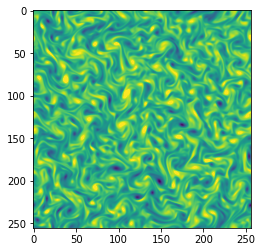

In [8]:
# load image
from scipy.io import loadmat
image = loadmat(save_dir + 'turbulence2d.mat')['imgs'].transpose((-1,0,1))
# image = ST.remove_slope(image)
image = image[:,:M,:N]

# define calculator
device = 'gpu' # 'cpu'
M = 256
N = M
J = 7
L = 4
filters_set = ST.FiltersSet(M=M, N=N, J=J, L=L).generate_morlet(
    if_save=False, save_dir=None, precision='single'
)
# filters_set = ST.FiltersSet(M=M, N=N, J=J, L=L).generate_bump_steerable(
#     if_save=False, save_dir=None, precision='single'
# )
ST_calculator = ST.ST_2D(filters_set, J, L, device=device, weight=None)
image_torch = torch.from_numpy(image)
if device=='gpu':
  image_torch = image_torch.cuda()

plt.imshow(image[0], vmax=np.percentile(image, 99))
plt.show()

PH+hist7


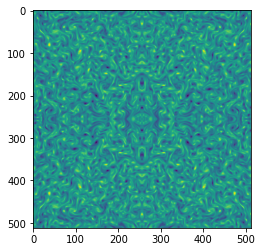

tensor(896, device='cuda:0')
0
loss:  tensor(424612.6562, device='cuda:0', grad_fn=<AddBackward0>)
loss_hist:  tensor(238921.5312, device='cuda:0', grad_fn=<MulBackward0>)
loss_PH00:  tensor(6.0308, device='cuda:0', grad_fn=<MulBackward0>)
loss_S1:  tensor(30.8159, device='cuda:0', grad_fn=<MulBackward0>)
loss_C01:  tensor(1114.2970, device='cuda:0', grad_fn=<MulBackward0>)
loss_PH11diag:  tensor(92147.1953, device='cuda:0', grad_fn=<MulBackward0>)
loss_PH11:  tensor(90247.6797, device='cuda:0', grad_fn=<MulBackward0>)
0
loss:  tensor(424592.8438, device='cuda:0', grad_fn=<AddBackward0>)
loss_hist:  tensor(238921.5312, device='cuda:0', grad_fn=<MulBackward0>)
loss_PH00:  tensor(6.0308, device='cuda:0', grad_fn=<MulBackward0>)
loss_S1:  tensor(30.8158, device='cuda:0', grad_fn=<MulBackward0>)
loss_C01:  tensor(1114.2734, device='cuda:0', grad_fn=<MulBackward0>)
loss_PH11diag:  tensor(92129.7344, device='cuda:0', grad_fn=<MulBackward0>)
loss_PH11:  tensor(90245.3594, device='cuda:0', gra

In [9]:
# synthesis

for coef in [
    'PH+hist7',
]:
    print(coef)
    device = 'gpu'
    N_realization = 1
    image_init = None#synthesised_image#
    J = 7
    L = 4
    torch.autograd.set_detect_anomaly(False)

    for random_seed in [987]:
        synthesised_image = image_synthesis(
            image[:N_realization],
            J=J, L=L,
            N_realization = N_realization,
            learnable_param_list = [
                (2, 2e-1),
            ],
            savedir = save_dir,
            device = device,
            coef = coef,
            random_seed = random_seed,
            starting_power_factor = 1,
            starting_image = image_init,
            flip=1,
            optim_mode='LBFGS',
            filter='gau'
        )
        # np.save(save_dir +'synthesised_turing_pattern.npy', synthesised_image)
        print(image.std(),  synthesised_image.std())

In [13]:
np.arange(len(image))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

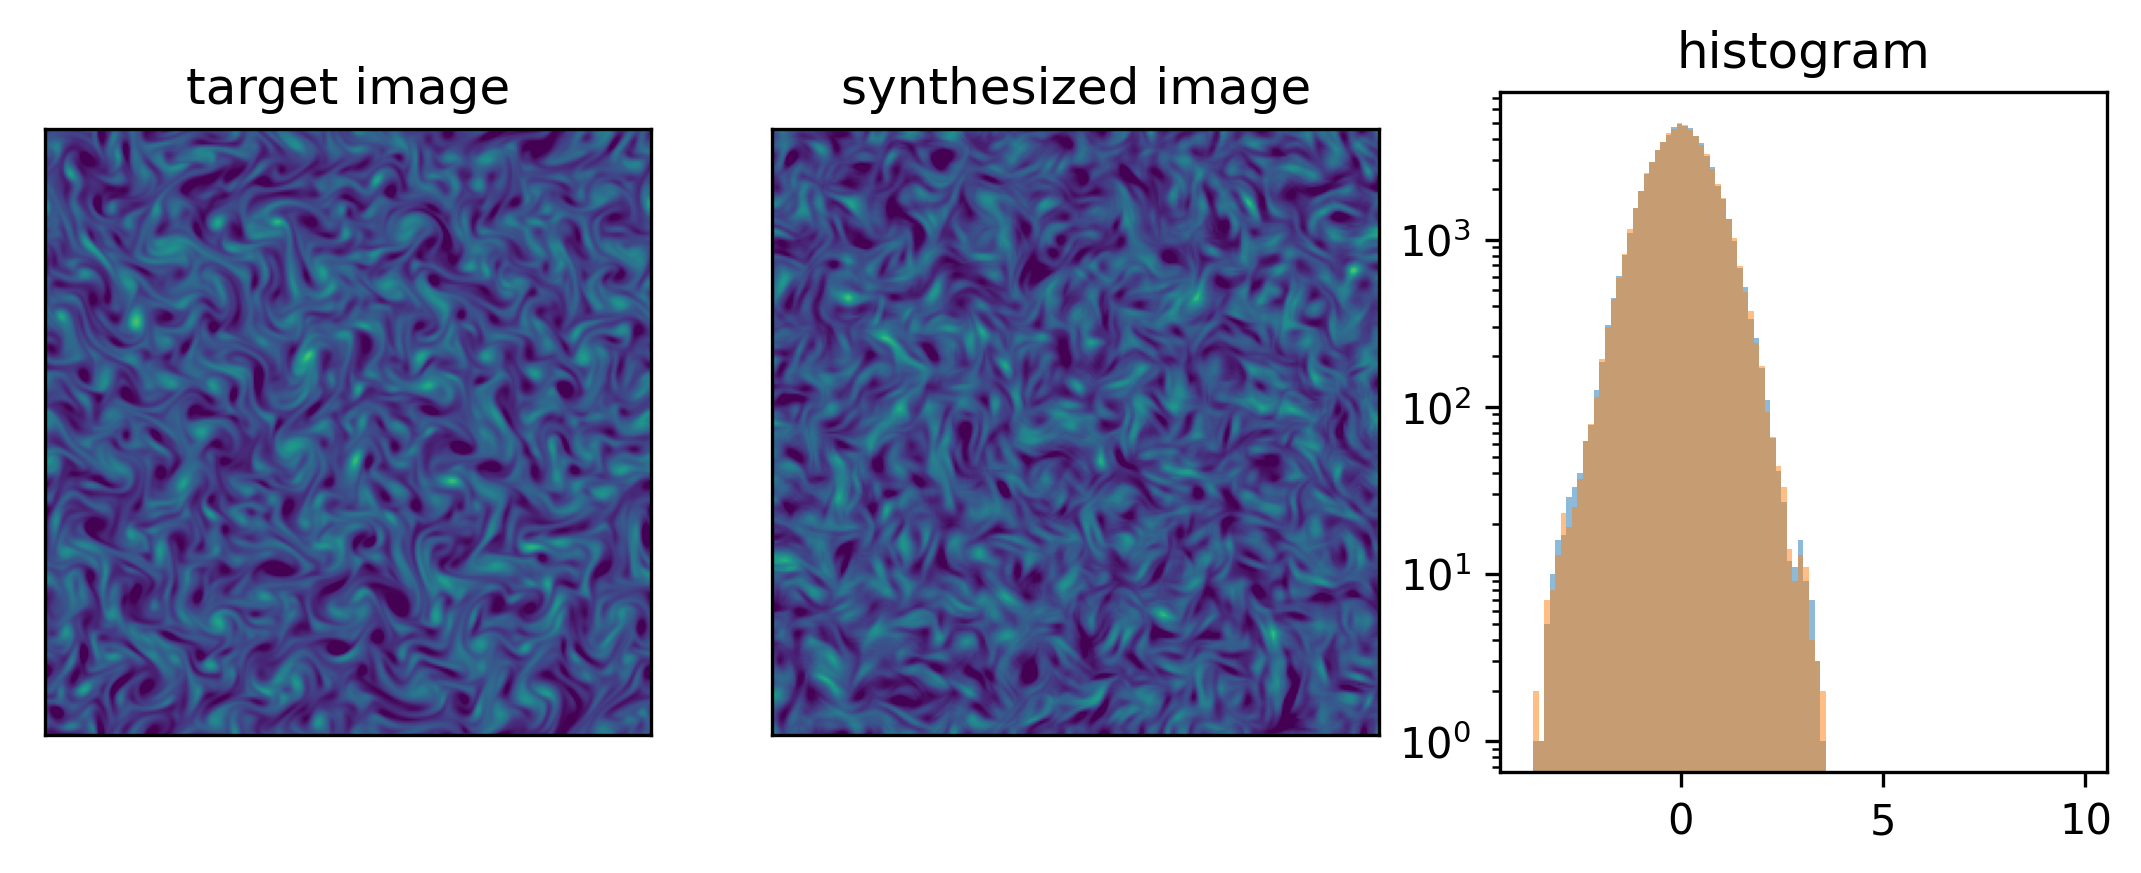

In [15]:
crop = 256#236
shift = 0
for index in range(N_realization):
    # synthesised_image = np.load(save_dir +'synthesised_lensing_hist7.npy')
    plt.figure(figsize=(12,3),dpi=300)
    plt.subplot(141)
    plt.imshow(image[index,shift:shift+crop,shift:shift+crop],
              vmin=image[index].mean()-image[index].std()*2, 
              vmax=image[index].mean()+image[index].std()*7, 
              # cmap='gray',
              #  vmin=-0.04, vmax=0.1, 
                )
    plt.title('target image')
    plt.xticks([]); plt.yticks([])

    plt.subplot(142)
    plt.imshow(synthesised_image[index,shift:shift+crop,shift:shift+crop],
              vmin=image[index].mean()-image[index].std()*2, 
              vmax=image[index].mean()+image[index].std()*7, 
              # cmap='gray',
              #  vmin=-0.04, vmax=0.1, 
                )
    plt.title('synthesized image')
    plt.xticks([]); plt.yticks([])

    plt.subplot(143)
    plt.hist(image[index,:crop,:crop].flatten(), 100, (image.mean()-image.std()*5, image.mean()+image.std()*13), alpha=0.5)
    plt.hist(synthesised_image[index,:crop,:crop].flatten(), 100, (image.mean()-image.std()*5, image.mean()+image.std()*13), alpha=0.5)
    plt.yscale('log')
    plt.title('histogram')

    plt.show()

# profiles of different wavelets

In [ ]:
import importlib
importlib.reload(ST)

M = 229
N = 253
J = 8
L = 4
filters_set_morlet = ST.FiltersSet(M=M, N=N, J=J, L=L).generate_morlet(
    if_save=False, save_dir=None, precision='single'
)
filters_set_gau = ST.FiltersSet(M=M, N=N, J=J, L=L).generate_gau_steerable(
    if_save=False, save_dir=None, precision='single'
)
filters_set = ST.FiltersSet(M=M, N=N, J=J, L=L).generate_bump_steerable(
    if_save=False, save_dir=None, precision='single'
)
ST_calculator = ST.ST_2D(filters_set, J, L, device='cpu')
random_test = torch.normal(0, 1, (1,M,N))#.cuda()

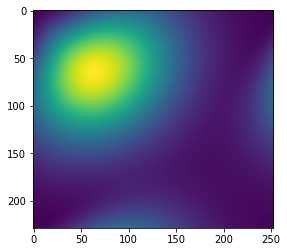

In [ ]:
plt.imshow(filters_set_gau['psi'][0,0])
plt.show()

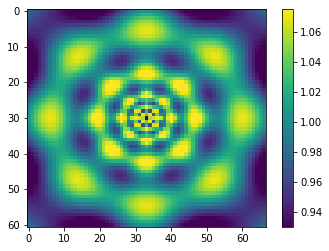

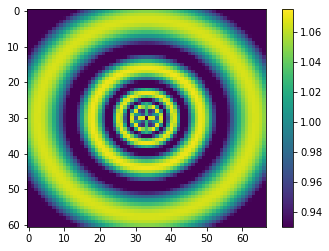

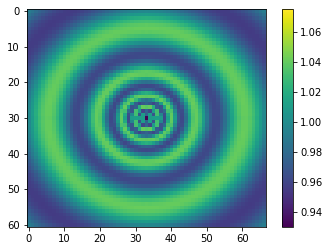

In [ ]:
a = filters_set_morlet['psi'][0,0] * 0.
b = filters_set['psi'][0,0] * 0.
c = filters_set_gau['psi'][0,0] * 0.
for j in range(J):
    for l in range(L):
        a += filters_set_morlet['psi'][j,l]**2
        b += filters_set['psi'][j,l]**2
        c += filters_set_gau['psi'][j,l]**2

for e in [a, b, c]:
    e = torch.fft.fftshift(e)
    e = e + torch.flip(e,dims=(0,1))#.roll(1,0).roll(1,1)
    e = e / e[M//8*3:M-M//8*3, N//8*3:N-N//8*3].mean()
    plt.imshow(
        e[M//8*3:M-M//8*3, N//8*3:N-N//8*3], 
        vmin=0.93, vmax=1/0.93 )
    plt.colorbar()
    plt.show()

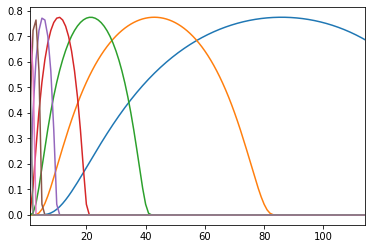

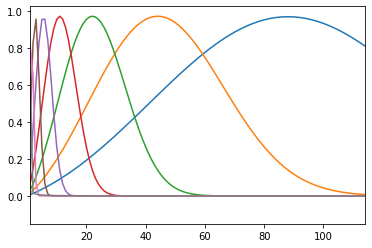

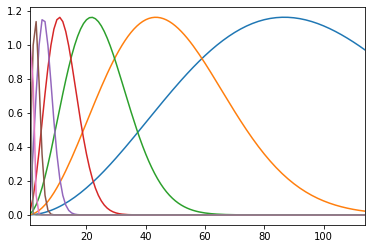

In [ ]:
for filter in [
    filters_set, 
    filters_set_morlet, 
    filters_set_gau
]:
    for j in range(J):
        plt.plot(filter['psi'][j,1][:,0])
    plt.xlim(1,M//2)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()